In [1]:
import numpy as np
from termcolor import colored

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [2]:
def comparator(learner, instructor):
    if len(learner) != len(instructor):
        raise AssertionError(f"The number of layers in the proposed model does not agree with the expected model: expected {len(instructor)}, got {len(learner)}.")
    for a, b in zip(learner, instructor):
        if tuple(a) != tuple(b):
            print(colored("Test failed", attrs=['bold']),
                  "\n Expected value \n\n", colored(f"{b}", "green"),
                  "\n\n does not match the input value: \n\n",
                  colored(f"{a}", "red"))
            raise AssertionError("Error in test")
    print(colored("All tests passed!", "green"))

In [3]:
def summary(model):
    result = []
    for layer in model.layers:
        # Safely get the output shape
        try:
            output_shape = layer.output.shape
        except AttributeError:
            output_shape = getattr(layer, 'batch_input_shape', 'unknown')

        # Safely get parameters
        try:
            params = layer.count_params()
        except:
            params = 0

        descriptors = [layer.__class__.__name__, output_shape, params]

        if isinstance(layer, Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if isinstance(layer, MaxPooling2D):
            descriptors.append(layer.pool_size)
        if isinstance(layer, Dropout):
            descriptors.append(layer.rate)

        result.append(descriptors)
    return result

In [6]:
import tensorflow as tf
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras import Model

In [7]:
from google.colab import drive


drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
image_path = r"/content/drive/MyDrive/Data/CameraRGB"
mask_path = r"/content/drive/MyDrive/Data/CameraMask"

In [9]:
image_list = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.png')]
mask_list = [os.path.join(mask_path, f) for f in os.listdir(mask_path) if f.endswith('.png')]

image_list.sort()
mask_list.sort()

/tmp/ipython-input-2711689936.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/tmp/ipython-input-2711689936.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


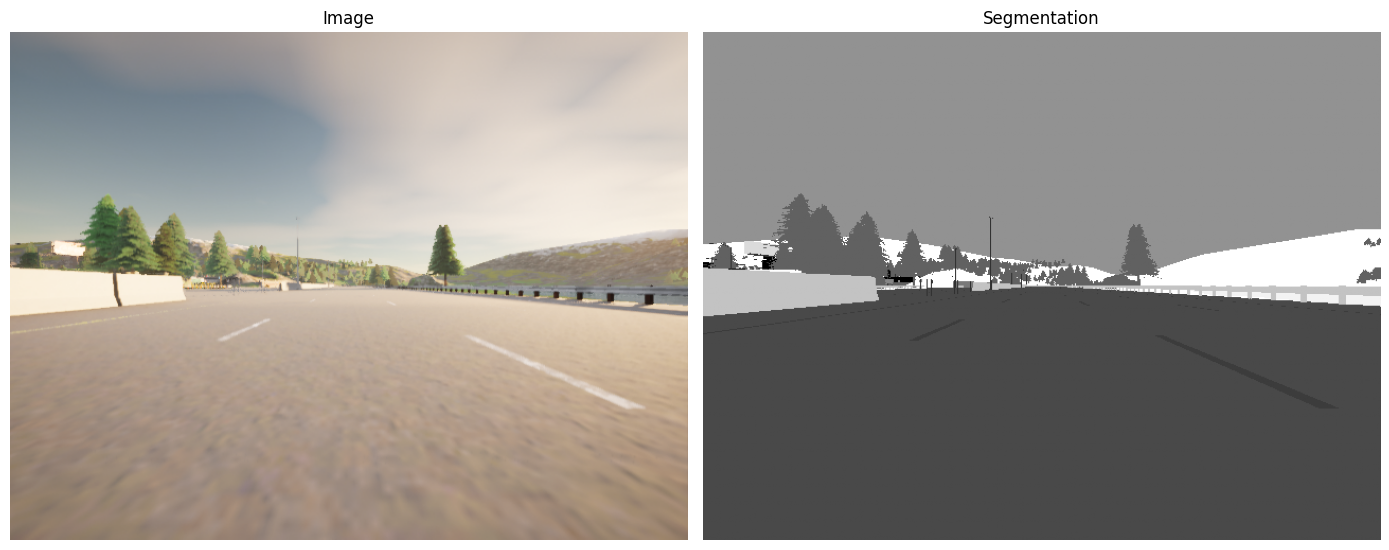

In [10]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[0].axis('off')

if mask.ndim == 3:
    arr[1].imshow(mask[:, :, 0], cmap='gray')
else:
    arr[1].imshow(mask, cmap='gray')
arr[1].set_title('Segmentation')
arr[1].axis('off')
plt.tight_layout()
plt.show()

In [11]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/Data/CameraMask/000028.png'>)
tf.Tensor(b'/content/drive/MyDrive/Data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/Data/CameraMask/000026.png', shape=(), dtype=string)


In [12]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)


In [13]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)


    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
next_layer, skip_connection = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=next_layer)


In [14]:
output1 = [
    ['InputLayer', (None, 96, 128, 3), 0],
    ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
    ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
    ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)
inputs = Input(input_size)
next_layer, skip_connection = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=next_layer)

Block 1:
['InputLayer', (None, 96, 128, 3), 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
All tests passed!


In [15]:
output2 = [
    ['InputLayer', (None, 96, 128, 3), 0],
    ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
    ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
    ['Dropout', (None, 96, 128, 1024), 0, 0.1],
    ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
]

print('\nBlock 2:')
for layer in summary(model2):
    print(layer)

comparator(summary(model2), output2)


Block 2:
['InputLayer', (None, 96, 128, 3), 0]
['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 96, 128, 1024), 0, 0.1]
['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
All tests passed!


In [16]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,
                 3,
                 strides=2,
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    return conv


In [17]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

In [18]:
output1 = [
    ['InputLayer', (None, 12, 16, 256), 0],
    ['Conv2DTranspose', (None, 24, 32, 32), 73760],
    ['InputLayer', (None, 24, 32, 128), 0],
    ['Concatenate', (None, 24, 32, 160), 0],
    ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
    ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
]


print('Block 1:')
for layer in summary(model1):
    print(layer)
comparator(summary(model1), output1)

Block 1:
['InputLayer', (None, 12, 16, 256), 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', (None, 24, 32, 128), 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
All tests passed!


In [19]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)

    # Contracting Path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Expanding Path
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same', activation='softmax')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model


In [20]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 96, 128,   │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 96, 128,   │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 48, 64,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 48, 64,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 48, 64,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 24, 32,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 24, 32,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 24, 32,    │    147,584 │ conv2d_10[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 12, 16,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 12, 16,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 12, 16,    │    590,080 │ conv2d_12[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 16,    │          0 │ conv2d_13[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 6, 8, 256) │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 6, 8, 512) │  1,180,160 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 6, 8, 512) │  2,359,808 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 6, 8, 512) │          0 │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 12, 16,    │  1,179,904 │ dropout_2[0][0] 

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


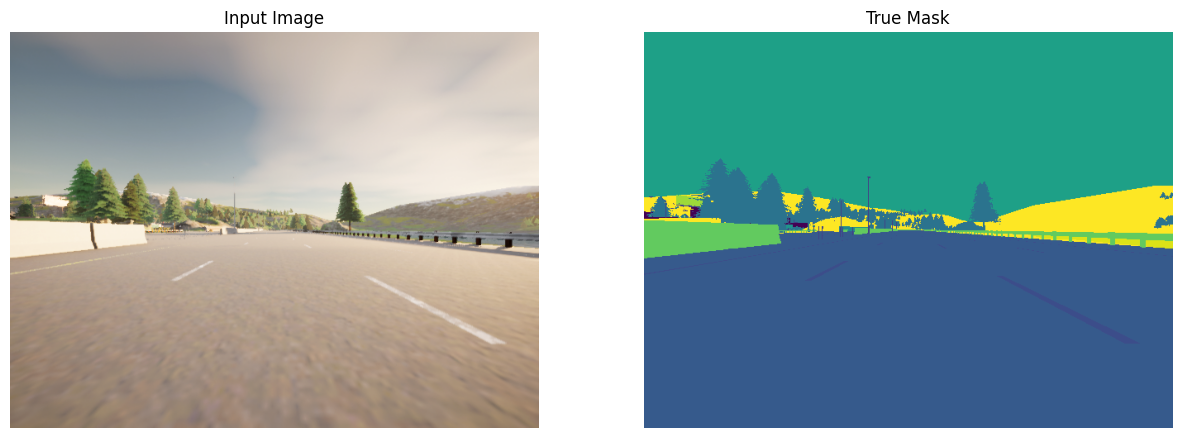

(96, 128, 1)


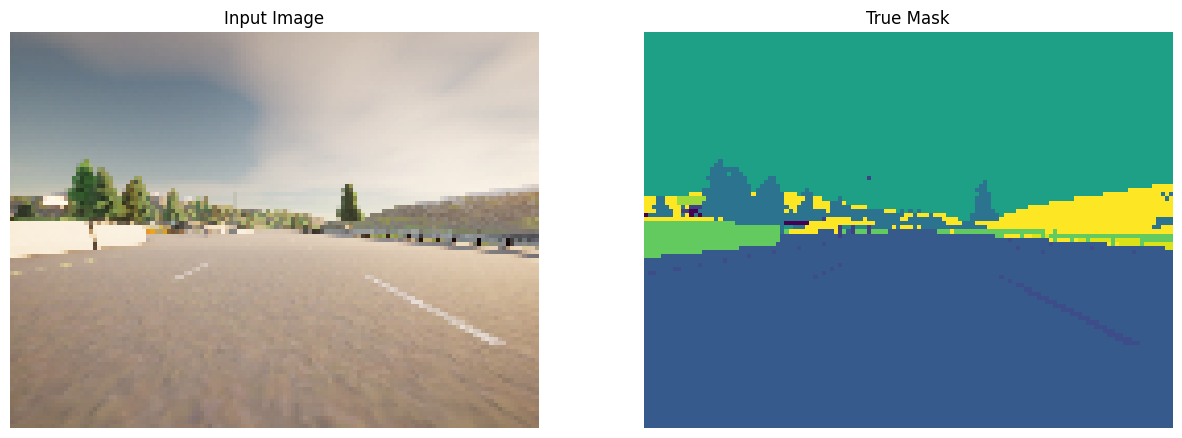

In [23]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])
#new

for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])



In [24]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


12/34 ━━━━━━━━━━━━━━━━━━━━ 2:22 6s/step - accuracy: 0.2810 - loss: 3.4111

KeyboardInterrupt: 

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

plt.plot(model_history.history["accuracy"])

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

show_predictions(train_dataset, 6)